# ANÁLISIS DE SENTIMIENTO Y CATEGORIZACIÓN DE TEXTO (MODELO NO ENTRENADO Y CLASIFICANDO POR POLARIZACIÓN)

In [11]:
### LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
# MODELO BERT PARA ANÁLISIS DE TEXTO

sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


Device set to use cuda:0


In [13]:
### FUENTE DE DATOS

file_path = 'https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/Data%20Sources/Comments.csv'
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')

# Limpieza: eliminar filas donde 'TRANSLATED COMMENTS' solo contiene "..." o está vacía
df = df[~df["TRANSLATED COMMENTS"].str.strip().isin(["", "..."])]


In [14]:
### ANÁLISIS DE SENTIMIENTOS Y ASIGNACIÓN DE ISSUES

def analyze_sentiment(comment):
    comment = str(comment).strip()
    if not comment or comment == "nan":
        return "NEUTRAL", 0.0
    result = sentiment_analyzer(comment, truncation=True, max_length=512)[0]
    label = result['label']
    score = result['score']
    if label == "POSITIVE":
        polarity = score
        sentiment = "Positive" if score > 0.7 else "Neutral"
    else:
        polarity = -score
        sentiment = "Negative" if score > 0.7 else "Neutral"
    return sentiment, polarity

df[['sentiment', 'polarity']] = df["TRANSLATED COMMENTS"].apply(analyze_sentiment).apply(pd.Series)

print("Distribución de sentimientos:")
print(df['sentiment'].value_counts())

df_nn = df[df['sentiment'].isin(['Negative', 'Neutral'])].copy()
comments_nn = df_nn["TRANSLATED COMMENTS"].tolist()
print(f"\nNúmero de comentarios Negativos y Neutrales: {len(comments_nn)}")

print("\nEjemplos de comentarios con puntajes:")
print(df[["TRANSLATED COMMENTS", 'sentiment', 'polarity']].head(10))

# Listado predefinido de issues y sus palabras clave para clasificar comentarios por tópicos

predefined_issues = {
    "Slow Response/Delay Issues": ["faster","feedback","slow", "answer", "solution" , "wait", "long", "wait", "late", "take", "forever", "reply", "frustrate"],
    "Poor Agent Knowledge": ["know", "prepare", "confuse", "wrong", "incompetent", "expert"],
    "Poor Support Quality": ["rude", "help", "attitude", "confuse", "incompetent", "understand", "agent"],
    "Fraud/Trust Issues": ["fraud", "scam", "trust", "secure", "money", "pay", "fake", "hack", "safe"],
    "Product and Services": ["account", "service", "term", "policy", "product", "avail", "refund"],
    "Platform Functionality": ["app","api","platform", "system", "error", "bug", "crash", "technical", "happen"],
    "Lack of Communication Channels": ["phone", "email", "contact", "call", "chat", "verbal","operator","agent"],
    "Lack of Response": ["assistance","receive","any","request", "support" ,"contact","respond", "answer", "no one", "get", "feedback", "question", "nobody", "silent","call"],
    "Ineffective Resolution": ["unsuccessful","request","resolve", "problem", "solve", "fix", "nothing", "resolution"],
    "Language Barriers": ["portuguese", "help", "speaker", "native", "spanish", "english", "language", "italian", "translate", "speak"]
}



def lemmatize_text(text):
    words = word_tokenize(text.lower())
    lemmatized_words = {lemmatizer.lemmatize(word) for word in words}
    return lemmatized_words

# Asignación de issues a los comentarios

def assign_issue(comment):
    comment_words = lemmatize_text(comment)
    max_overlap = 0
    best_issue = "Other Issues"
    for issue, issue_keywords in predefined_issues.items():
        overlap = len(comment_words.intersection(set(issue_keywords)))
        if overlap > max_overlap or (overlap == max_overlap and issue in ["Lack of Response", "Language Barriers", "Platform Functionality", "Poor Support Quality", "Poor Agent Knowledge", "Product and Services", "Fraud/Trust Issues", "Lack of Communication Channels"]):
            max_overlap = overlap
            best_issue = issue
    return best_issue if max_overlap > 0 else "Other Issues"


df_nn['issue'] = df_nn["TRANSLATED COMMENTS"].apply(assign_issue)

# Visualización de comentarios con sus sentimientos y issues asignados

print("\nComentarios con sus issues asignados:")
print(df_nn[["TRANSLATED COMMENTS", 'sentiment', 'polarity', 'issue']])


Distribución de sentimientos:
sentiment
Negative    177
Positive    127
Neutral       6
Name: count, dtype: int64

Número de comentarios Negativos y Neutrales: 183

Ejemplos de comentarios con puntajes:
                                  TRANSLATED COMMENTS sentiment  polarity
1                       ...but your reply was good :)  Positive  0.994082
2                    ...I didn't even get a response!  Negative -0.999758
3                       2 weeks and no resolution yet  Negative -0.998362
4                A little late but perfect in the end  Positive  0.999673
5                      A wonderful support. Thank you  Positive  0.999871
6   Above all, I have the impression that it was a...  Positive  0.919809
7           Accurate Fast Perfect Thank you very much  Positive  0.999876
8   After a few days I found out on my own how to ...  Negative -0.999192
9                       all super and thanks for help  Positive  0.999541
10              All the information was very complete  Po

<ipython-input-15-35f8cd9c82c4>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_percentages.index, y=sentiment_percentages.values, palette=sentiment_colors)


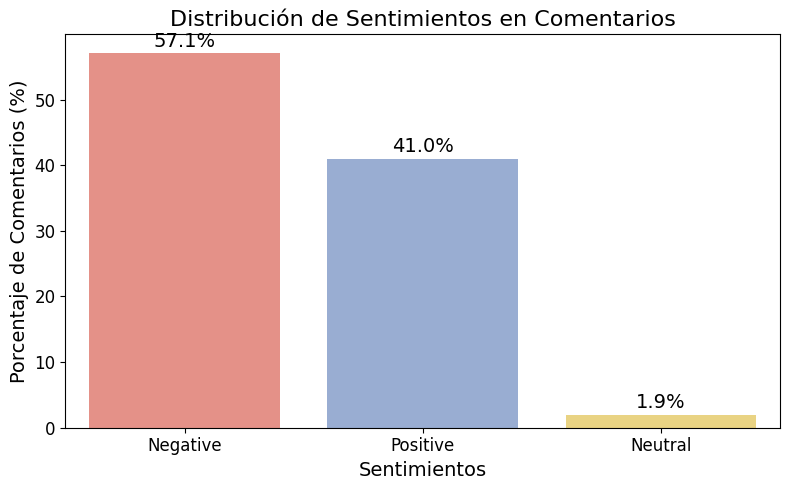

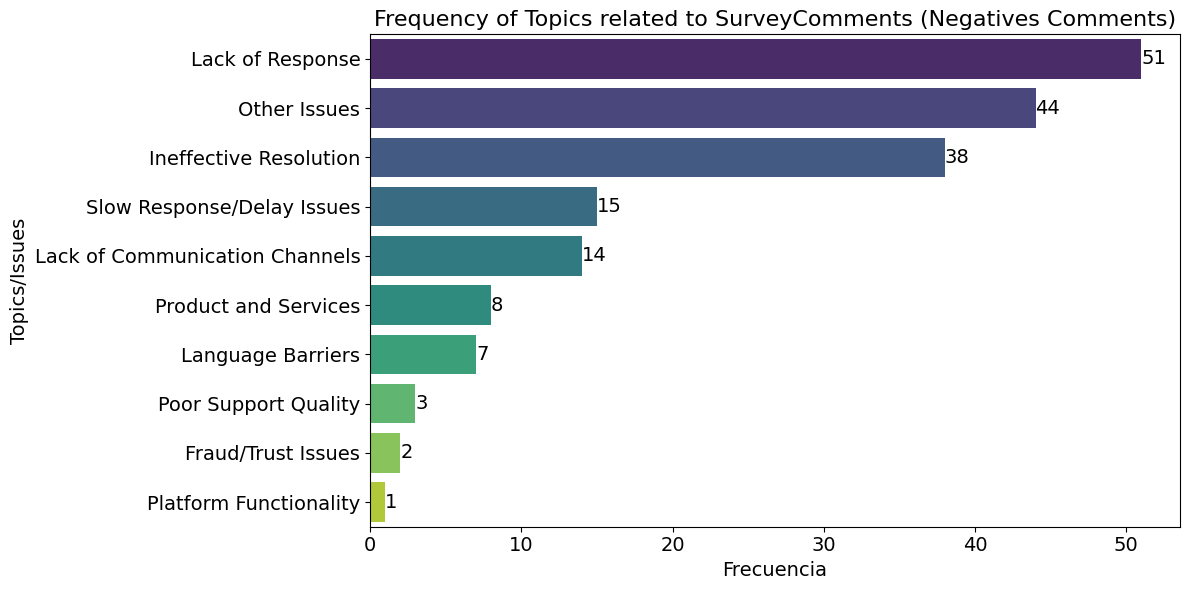

In [15]:

### VISUALIZACIÓN DE GRÁFICOS DE SENTIMIENTOS E ISSUES

## PROPORCIÓN DE SENTIMIENTOS

sentiment_colors = {
    'Positive': '#8FAADC',
    'Neutral': '#FADD72',
    'Negative': '#F38579'
}


sentiment_counts = df['sentiment'].value_counts()
total_comments = sentiment_counts.sum()


sentiment_percentages = (sentiment_counts / total_comments) * 100


plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_percentages.index, y=sentiment_percentages.values, palette=sentiment_colors)
plt.xlabel('Sentimientos', size=14)
plt.ylabel('Porcentaje de Comentarios (%)', size=14)
plt.title('Distribución de Sentimientos en Comentarios', size=16)


for i, v in enumerate(sentiment_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', size=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## CANTIDAD DE ISSUES PARA COMENTARIOS NEGATIVOS Y NEUTRALES

plt.figure(figsize=(12, 6))
issue_counts = df_nn['issue'].value_counts()
sns.barplot(x=issue_counts.values, y=issue_counts.index, palette="viridis", hue=issue_counts.index)
plt.xlabel('Frecuencia', size=14)
plt.ylabel('Topics/Issues', size=14)
plt.title('Frequency of Topics related to SurveyComments (Negatives Comments)', size=16)
for i, v in enumerate(issue_counts.values):
    plt.text(v, i, str(v), va='center', size=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
df_nn.head(25)

,TRANSLATED COMMENTS,sentiment,polarity,issue
2,...I didn't even get a response!,Negative,-0.999758,Lack of Response
3,2 weeks and no resolution yet,Negative,-0.998362,Ineffective Resolution
8,After a few days I found out on my own how to ...,Negative,-0.999192,Ineffective Resolution
16,assistance on missed collections.,Negative,-0.985095,Lack of Response
17,At first it seemed like he didn't understand w...,Negative,-0.996610,Lack of Communication Channels
18,bad,Negative,-0.999782,Other Issues
19,Basically a nice chat but the answer was compl...,Negative,-0.997492,Fraud/Trust Issues
20,being a bit faster in answering.,Neutral,-0.661154,Slow Response/Delay Issues
21,Call with Italian operator,Negative,-0.766389,Lack of Communication Channels
22,Cancel my Stripe account,Negative,-0.999675,Product and Services


SOLO NEGATIVOS

In [ ]:
##df_nn.to_excel('C:/Users/joey_/Desktop/DESK 2025/DB (RESPALDOS)/Sentiments and Topics.xlsx', index=False)

# MODELO DE ANÁLISIS DE SENTIMIENTO BERT (ENTRENADO)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


In [35]:


# 3. Cargar el dataset de Hugging Face
dataset = load_dataset("app_reviews")

for split in dataset.keys():
    dataset[split] = dataset[split].shuffle(seed=42).select(range(int(1.0 * len(dataset[split]))))

# 4. Preprocesar los datos
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizar los datasets
def tokenize_function(examples):
    return tokenizer([str(text) for text in examples['text']], padding="max_length", truncation=True)

# Tokenizar los datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 5. Preparar los datos para el entrenamiento
def label_to_int(label):
    if label == "positive":
        return 0
    elif label == "neutral":
        return 1
    elif label == "negative":
        return 2
    else:
        return -1  # Para manejar etiquetas no válidas

# Convertir las etiquetas a enteros
tokenized_datasets = tokenized_datasets.map(lambda x: {'label': label_to_int(x['sentiment'])})

# 6. Entrenar un modelo de análisis de sentimientos
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Evaluar cada cierto número de pasos
    eval_steps=500,  # Evaluar cada 500 pasos
    save_strategy="steps",  # Guardar cada cierto número de pasos
    save_steps=500,  # Guardar cada 500 pasos
    learning_rate=2e-5,  # Mantener, pero podemos experimentar con 3e-5 si es necesario
    per_device_train_batch_size=8,  # Reducir para evitar problemas de memoria
    per_device_eval_batch_size=8,  # Reducir para evaluación
    gradient_accumulation_steps=2,  # Acumular gradientes para simular un batch size de 16 (8 x 2)
    num_train_epochs=3,  # Reducir a 3 épocas, ya que el sobreajuste comienza en la época 3
    weight_decay=0.1,  # Aumentar para mayor regularización
    logging_dir='./logs',
    logging_steps=50,  # Reducir la frecuencia de logging
    load_best_model_at_end=True,  # Cargar el mejor modelo al final
    metric_for_best_model="eval_loss",  # Usar la pérdida de validación para seleccionar el mejor modelo
    greater_is_better=False,  # Menor pérdida de validación es mejor
    fp16=True,  # Habilitar mixed precision para ahorrar memoria y acelerar
    warmup_steps=500,  # Añadir warmup para estabilizar el entrenamiento
    max_grad_norm=1.0,  # Añadir gradient clipping para evitar gradientes explosivos
    save_total_limit=2,  # Limitar el número de checkpoints guardados
)

# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

# Entrenar el modelo
trainer.train()

# 7. Evaluar el modelo
trainer.evaluate()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/31232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5205 [00:00<?, ? examples/s]

Map:   0%|          | 0/5206 [00:00<?, ? examples/s]

Map:   0%|          | 0/31232 [00:00<?, ? examples/s]

Map:   0%|          | 0/5205 [00:00<?, ? examples/s]

Map:   0%|          | 0/5206 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
500,0.721400,0.650911
1000,0.597300,0.604327
1500,0.583100,0.608641
2000,0.494400,0.587335
2500,0.457300,0.610565
3000,0.457700,0.619534
3500,0.450900,0.589777
4000,0.316500,0.643444
4500,0.325800,0.681214
5000,0.308600,0.693279


{'eval_loss': 0.5873347520828247,
 'eval_runtime': 40.2354,
 'eval_samples_per_second': 129.389,
 'eval_steps_per_second': 16.18,
 'epoch': 3.0}

In [36]:
# 8. Evaluar el modelo
eval_results = trainer.evaluate()

# Obtener las predicciones del conjunto de prueba
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calcular la precisión del modelo
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.7643
Precision: 0.7655
Recall: 0.7643
F1-Score: 0.7648


<ipython-input-52-6cb9850a5816>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_proportions.index, y=sentiment_proportions.values, palette=sentiment_colors)


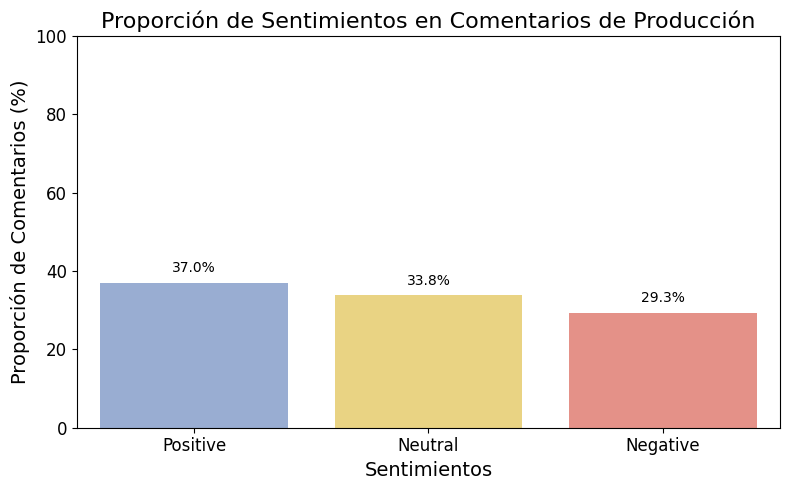

In [52]:
# 9. Cargar el CSV de producción
file_path = 'https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/Data%20Sources/Comments.csv'
df_production = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
df_production['TRANSLATED COMMENTS'] = df_production['TRANSLATED COMMENTS'].astype(str)

# Tokenizar los comentarios de producción
production_encodings = tokenizer(df_production['TRANSLATED COMMENTS'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Mover los tensores de entrada a la GPU si está disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    production_encodings = production_encodings.to(device)
    model = model.to(device) # Move the model to the same device

# Hacer predicciones
with torch.no_grad():
    outputs = model(**production_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Agregar las predicciones al DataFrame
df_production['predicted_sentiment'] = predictions.cpu().numpy() # Move predictions back to CPU if necessary

import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_production' contenga la columna 'predicted_sentiment'
# con las predicciones del modelo BERT entrenado.

# Mapea las predicciones numéricas a etiquetas de sentimiento
def map_sentiment(prediction):
    if prediction == 0:
        return "Positive"
    elif prediction == 1:
        return "Neutral"
    elif prediction == 2:
        return "Negative"
    else:
        return "Unknown"  # Manejar predicciones inesperadas

df_production['predicted_sentiment_label'] = df_production['predicted_sentiment'].apply(map_sentiment)

# Calcula la proporción de cada sentimiento y convierte a porcentaje
sentiment_counts = df_production['predicted_sentiment_label'].value_counts()
total_comments = sentiment_counts.sum()
sentiment_proportions = (sentiment_counts / total_comments) * 100  # Convertir a porcentaje

sentiment_colors = {
    'Positive': '#8FAADC',
    'Neutral': '#FADD72',
    'Negative': '#F38579'
}

# Crea el gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_proportions.index, y=sentiment_proportions.values, palette=sentiment_colors)
plt.xlabel('Sentimientos', size=14)
plt.ylabel('Proporción de Comentarios (%)', size=14) # Cambiar la etiqueta del eje Y
plt.title('Proporción de Sentimientos en Comentarios de Producción', size=16)

# Ajustar la escala del eje Y de 0 a 100
plt.ylim(0, 100)

# Agregar etiquetas de porcentaje a las barras
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x() + width / 2
    y = height + 2  # Ajusta el espaciado vertical de la etiqueta
    label_text = f'{height:.1f}%'  # Agregar el símbolo de porcentaje a la etiqueta
    ax.text(x, y, label_text, ha='center', va='bottom', fontsize=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [48]:
df_production.head(25)

,TRANSLATED COMMENTS,predicted_sentiment,predicted_sentiment_label
0,...,1,Neutral
1,...but your reply was good :),0,Positive
2,...I didn't even get a response!,1,Neutral
3,2 weeks and no resolution yet,1,Neutral
4,A little late but perfect in the end,0,Positive
5,A wonderful support. Thank you,0,Positive
6,"Above all, I have the impression that it was a...",0,Positive
7,Accurate Fast Perfect Thank you very much,0,Positive
8,After a few days I found out on my own how to ...,1,Neutral
9,all super and thanks for help,0,Positive


In [51]:
from google.colab import files
df_production.to_excel('Sentiments (Model).xlsx', index=False)
files.download('Sentiments (Model).xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MODELO 2

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

# 1. Cargar el 50% del dataset de Hugging Face
dataset = load_dataset("sealuzh/app_reviews", split="train[:10%]")

# 2. Dividir el dataset en train y test (70% train, 30% test)
train_test_split = dataset.train_test_split(test_size=0.3, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# 2. Preprocesar los datos: Recategorizar la columna "star" a 3 clases
def map_to_sentiment(examples):
    star = examples["star"]
    if star >= 4:  # 4-5: Positivo
        return {"label": 0}
    elif star == 3:  # 3: Neutral
        return {"label": 1}
    else:  # 1-2: Negativo
        return {"label": 2}

# Aplicar la recategorización
train_dataset = train_dataset.map(map_to_sentiment)
test_dataset = test_dataset.map(map_to_sentiment)

# 3. Cargar el tokenizador y tokenizar los datos
model_name = "bert-base-uncased"  # Cambiar a BERT-Base (no destilado)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer([str(text) for text in examples["review"]], padding="max_length", truncation=True, max_length=128)

# Tokenizar los datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Preparar los datos para PyTorch
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/8642 [00:00<?, ? examples/s]

In [13]:

# 4. Cargar el modelo
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 5. Configurar los argumentos de entrenamiento optimizados para GPU
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Aumentar el tamaño del batch
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Mantener bajo para pruebas
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=15,  # Aumentar el intervalo de logging
    load_best_model_at_end=True,
    fp16=True,  # Habilitar mixed precision
)

# 6. Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

# 7. Entrenar el modelo
trainer.train()

# 8. Evaluar el modelo
eval_results = trainer.evaluate()
print("Resultados de Evaluación:", eval_results)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Exception ignored in: <function Dataset.__del__ at 0x7f60410ca5c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py", line 1410, in __del__
    def __del__(self):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# 8. Evaluar el modelo
eval_results = trainer.evaluate()

# Obtener las predicciones del conjunto de prueba
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calcular la precisión del modelo
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# 9. Cargar el CSV de producción
file_path = 'https://raw.githubusercontent.com/ringoquimico/Portfolio/refs/heads/main/Data%20Sources/Comments.csv'
df_production = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
df_production['TRANSLATED COMMENTS'] = df_production['TRANSLATED COMMENTS'].astype(str)

# Tokenizar los comentarios de producción
production_encodings = tokenizer(df_production['TRANSLATED COMMENTS'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Mover los tensores de entrada a la GPU si está disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    production_encodings = production_encodings.to(device)
    model = model.to(device) # Move the model to the same device

# Hacer predicciones
with torch.no_grad():
    outputs = model(**production_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Agregar las predicciones al DataFrame
df_production['predicted_sentiment'] = predictions.cpu().numpy() # Move predictions back to CPU if necessary

import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'df_production' contenga la columna 'predicted_sentiment'
# con las predicciones del modelo BERT entrenado.

# Mapea las predicciones numéricas a etiquetas de sentimiento
def map_sentiment(prediction):
    if prediction == 0:
        return "Positive"
    elif prediction == 1:
        return "Neutral"
    elif prediction == 2:
        return "Negative"
    else:
        return "Unknown"  # Manejar predicciones inesperadas

df_production['predicted_sentiment_label'] = df_production['predicted_sentiment'].apply(map_sentiment)

# Calcula la proporción de cada sentimiento y convierte a porcentaje
sentiment_counts = df_production['predicted_sentiment_label'].value_counts()
total_comments = sentiment_counts.sum()
sentiment_proportions = (sentiment_counts / total_comments) * 100  # Convertir a porcentaje

sentiment_colors = {
    'Positive': '#8FAADC',
    'Neutral': '#FADD72',
    'Negative': '#F38579'
}

# Crea el gráfico de barras
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_proportions.index, y=sentiment_proportions.values, palette=sentiment_colors)
plt.xlabel('Sentimientos', size=14)
plt.ylabel('Proporción de Comentarios (%)', size=14) # Cambiar la etiqueta del eje Y
plt.title('Proporción de Sentimientos en Comentarios de Producción', size=16)

# Ajustar la escala del eje Y de 0 a 100
plt.ylim(0, 100)

# Agregar etiquetas de porcentaje a las barras
for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x() + width / 2
    y = height + 2  # Ajusta el espaciado vertical de la etiqueta
    label_text = f'{height:.1f}%'  # Agregar el símbolo de porcentaje a la etiqueta
    ax.text(x, y, label_text, ha='center', va='bottom', fontsize=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()